In [4]:
from ionqvision.ansatze.ansatz_library import AngleEncoder
from qiskit.circuit.library import EfficientSU2, TwoLocal, RealAmplitudes
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.circuit import ParameterVector
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from ionqvision.ansatze import VariationalAnsatz
import numpy as np
import symengine as symeng
from math import ceil, log
from ionqvision.ansatze import VariationalAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterExpression, ParameterVector
from qiskit.quantum_info import SparsePauliOp
# encoder = AngleEncoder(num_qubits=4)

In [5]:
class CustomEncoder(VariationalAnsatz):
    """
    Implement a quantum circuit for higher-order sparse angle encoding.
    """
    def __init__(self, num, reps = 1, param_prefix="x"):
        super().__init__(num)

        x = ParameterVector(param_prefix, num)
        enc = QuantumCircuit(num)
        for j in range(reps):
            for i in range(num):
                enc.rx(x[i], i)
        
        self.compose(enc, inplace=True)

In [6]:
n = 5

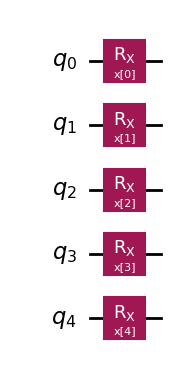

In [7]:
encoder =CustomEncoder(n, reps = 1)
encoder.draw("mpl")

In [8]:
class CustomAnsatz(VariationalAnsatz):
    """
    Implement a quantum circuit for higher-order sparse angle encoding.
    """
    def __init__(self, num_qubits, reps, param_prefix="θ"):
        super().__init__(num_qubits)

        theta = ParameterVector(param_prefix, num_qubits*3)
        qc = QuantumCircuit(num_qubits)
        for j in range(reps):
            for i in range(num_qubits):
                # for k in range(1,4):
                    qc.rz(theta[(i)*3], i)
                    qc.ry(theta[(i)*3 + 1], i) 
                    qc.rz(theta[(i)*3 + 2], i) 

            for i in range(num_qubits-1):
                qc.cx(i, i+1)

            qc.cx(num_qubits-1, 0)
            qc.barrier()
                    
        self.compose(qc, inplace=True)


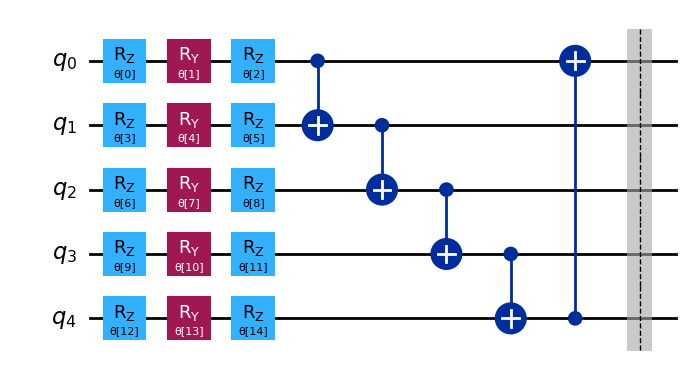

In [9]:
ansatz = CustomAnsatz(num_qubits=n, reps=1)
ansatz.draw("mpl")

In [10]:
from qiskit.quantum_info import SparsePauliOp

# Measure the expectation value of X_0, Y_0, Z_0
def feature_creation(n):
    return [SparsePauliOp(["Z" + "Z"*(n-1)])]
            # SparsePauliOp(["I"*(n-1) + "Y"]), 
            # SparsePauliOp(["I"*(n-1)  + "Z"])]

quantum_features = feature_creation(n)

In [11]:
quantum_features

[SparsePauliOp(['ZZZZZ'],
               coeffs=[1.+0.j])]

In [12]:
from ionqvision.modules import BinaryMNISTClassifier

# Set up your classifier and inspect its architecture
classifier = BinaryMNISTClassifier(encoder, ansatz, quantum_features);

INFO:qiskit.passmanager.base_tasks:Pass: ContainsInstruction - 0.01121 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.01311 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: HighLevelSynthesis - 0.06366 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: BasisTranslator - 0.07772 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ElidePermutations - 0.01264 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: RemoveDiagonalGatesBeforeMeasure - 0.05174 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: InverseCancellation - 0.12255 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutationAnalysis - 0.47779 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: CommutativeCancellation - 0.23055 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Collect2qBlocks - 0.06914 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: ConsolidateBlocks - 0.56410 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: Split2QUnitaries - 0.05388 (ms)
INFO:qiskit.passmanager.base_tasks:Pass: UnitarySynthesis - 0.00787 (ms)
INFO:qiskit.passm

In [13]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

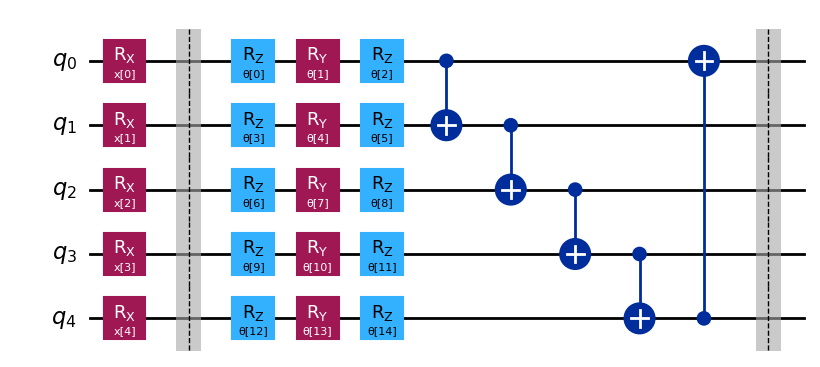

In [14]:
# Check out your quantum layer
classifier.quantum_layer.layer_qc.draw("mpl")

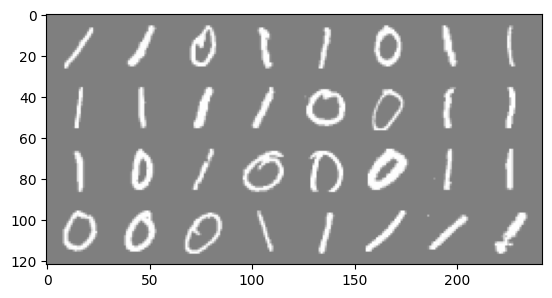

In [15]:
# Verify the images loaded correctly
classifier.visualize_batch()

In [16]:
%%time
# Get a (pre-processed) training and test set
train_set, test_set = classifier.get_train_test_set(train_size=300, test_size=100)

train_set

CPU times: user 259 ms, sys: 87.5 ms, total: 347 ms
Wall time: 165 ms


Dataset MNIST
    Number of datapoints: 300
    Root location: ./mnist-train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [17]:
train_set[0][0].shape

torch.Size([1, 28, 6])

epoch:   1 | loss: 0.717
lr: 0.1000 | processed     6/    6 batches per epoch in 99.28s (0.59s forward / 12.63s backward)
Model achieved 49.333%  accuracy on TRAIN set.
Model achieved 42.000%  accuracy on TEST set.

epoch:   2 | loss: 0.694
lr: 0.1000 | processed     6/    6 batches per epoch in 79.59s (0.44s forward / 13.32s backward)
Model achieved 49.333%  accuracy on TRAIN set.
Model achieved 58.000%  accuracy on TEST set.

epoch:   3 | loss: 0.702
lr: 0.1000 | processed     6/    6 batches per epoch in 79.63s (0.36s forward / 12.02s backward)
Model achieved 49.333%  accuracy on TRAIN set.
Model achieved 58.000%  accuracy on TEST set.

epoch:   4 | loss: 0.695
lr: 0.1000 | processed     6/    6 batches per epoch in 80.73s (0.46s forward / 12.46s backward)
Model achieved 43.000%  accuracy on TRAIN set.
Model achieved 39.000%  accuracy on TEST set.

epoch:   5 | loss: 0.696
lr: 0.1000 | processed     6/    6 batches per epoch in 79.52s (0.40s forward / 12.41s backward)
Model achieved

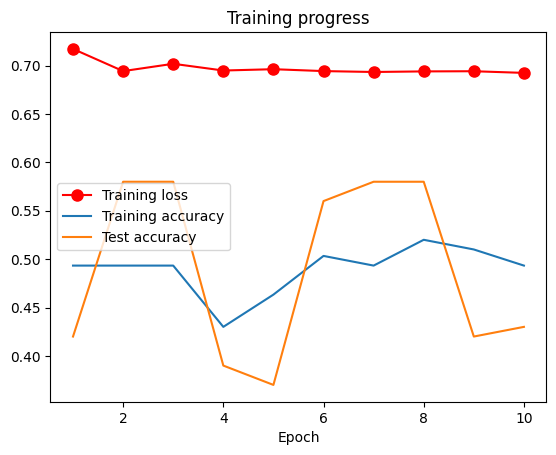

In [18]:
# Configure model training hyper parameters
config = {
    "epochs": 10,
    "lr": 0.1,
    "batch_size": 50,
    "betas": (0.9, 0.99),
    "weight_decay": 1e-3,
    "clip_grad": True,
    "log_interval": 6,
}

# Train and plot the results
classifier.train_module(train_set, test_set, config)
classifier.plot_training_progress()

In [ ]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

In [ ]:
submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

In [ ]:
client.await_autograder_result(submission_id=submission_id)